# Clustering Saham Berdasarkan Value-At Risk
Anggota Kelompok
1. Abdullah Nasih Jasir (5025211111)
2. Mohammad Ahnaf Fauzan (5025211170)
3. Al-Ferro Yudisthira Putra (5025211176)
# ---------------------------------------------------------------------------

### Import Libraries
Code di bawah guna melakukan import seluruh library yang dibutuhkan dalam final project ini

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.dates as mdates

plt.style.use('ggplot')
%matplotlib inline

### Import Data
Code berikut berguna untuk mengimport data dari file csv yang tersimpan di folder history

In [2]:
path = 'indonesia-stock-forecast/data/history'
all_rec = glob.iglob(path + '/*.csv', recursive=True)
count = 0

prices_df = pd.DataFrame()
for f in all_rec:
    count = count + 1
    df = pd.read_csv(f, index_col='Date', usecols=['Date', 'Close'])
    colname = os.path.basename(f).replace('.csv', '')
    df.rename(columns={'Close': colname}, inplace=True)
    prices_df = pd.concat([prices_df, df], axis=1, sort=False)

# Convert the 'Date' column to datetime format
prices_df.index = pd.to_datetime(prices_df.index)

# Define the date range
start_date = pd.to_datetime("2022-03-24")
end_date = pd.to_datetime("2023-03-24")

# Filter the data to include only the specified date range
prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]

# Filter stocks with at least 100 data points within the date range
valid_stocks = prices_df.columns[prices_df.count() >= 100]

# Create a new DataFrame with the selected date range and valid stocks
prices_train = prices_df[valid_stocks].loc[start_date:end_date]

prices_train.dropna(axis=0, how='any', inplace=True)

prices_train.head(10)

,AALI,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-07,8906.707031,230.0,6050.0,3700.0,680.0,200.0,77.0,7825.0,800.0,8225.0,...,95.0,540.0,234.0,91.0,635.0,2110.0,550.0,77.0,1075.0,515.0
2022-09-08,8906.707031,238.0,6050.0,3550.0,685.0,222.0,77.0,7775.0,810.0,8225.0,...,95.0,545.0,240.0,91.0,625.0,2110.0,550.0,77.0,1105.0,515.0
2022-09-09,8906.707031,230.0,6050.0,3600.0,675.0,220.0,77.0,7800.0,810.0,8225.0,...,95.0,540.0,240.0,93.0,625.0,2100.0,550.0,77.0,1100.0,520.0
2022-09-12,8931.448242,224.0,6050.0,3680.0,680.0,214.0,78.0,7775.0,815.0,8200.0,...,95.0,545.0,242.0,92.0,640.0,2080.0,550.0,78.0,1070.0,525.0
2022-09-13,9178.856445,226.0,5775.0,3780.0,680.0,222.0,88.0,7525.0,855.0,8200.0,...,95.0,575.0,256.0,92.0,620.0,2140.0,545.0,79.0,1055.0,530.0
2022-09-14,9104.633789,222.0,5525.0,3910.0,670.0,222.0,85.0,7600.0,855.0,8325.0,...,95.0,565.0,252.0,91.0,630.0,2060.0,545.0,78.0,1045.0,520.0
2022-09-15,9129.375000,212.0,5525.0,4700.0,670.0,216.0,83.0,7525.0,850.0,8350.0,...,95.0,565.0,254.0,91.0,635.0,2110.0,530.0,77.0,1075.0,520.0
2022-09-16,9005.670898,204.0,5625.0,4850.0,660.0,212.0,83.0,7350.0,850.0,8350.0,...,95.0,580.0,256.0,90.0,600.0,2060.0,525.0,76.0,1075.0,525.0
2022-09-19,8857.225586,210.0,5625.0,4720.0,660.0,208.0,80.0,7225.0,850.0,8375.0,...,95.0,575.0,256.0,93.0,625.0,2120.0,555.0,77.0,1080.0,515.0


# ---------------------------------------------------------------------------
## **PENCARIAN VALUE AT RISK**
# ---------------------------------------------------------------------------
Untuk mendapatkan Nilai dari VaR, kita memerlukan beberapa pencaharian terlebih dahulu, yaitu
1. Expected Values
2. Mean of Expected Values
3. Standard Deviation

### Expected Values
Berikut merupakan algoritma pencarian expected values

In [3]:
# Expected Value = Value(t) - Value(t-1) / Value(t-1)
expected_df = prices_train.copy()
for col in expected_df.columns:
    expected_df[col] = (prices_train[col] - prices_train[col].shift(1)) / prices_train[col].shift(1)
expected_df = expected_df.dropna()
expected_df.head()

,AALI,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-08,0.000000,0.034783,0.000000,-0.040541,0.007353,0.110000,0.000000,-0.006390,0.012500,0.000000,...,0.0,0.009259,0.025641,0.000000,-0.015748,0.000000,0.000000,0.000000,0.027907,0.000000
2022-09-09,0.000000,-0.033613,0.000000,0.014085,-0.014599,-0.009009,0.000000,0.003215,0.000000,0.000000,...,0.0,-0.009174,0.000000,0.021978,0.000000,-0.004739,0.000000,0.000000,-0.004525,0.009709
2022-09-12,0.002778,-0.026087,0.000000,0.022222,0.007407,-0.027273,0.012987,-0.003205,0.006173,-0.003040,...,0.0,0.009259,0.008333,-0.010753,0.024000,-0.009524,0.000000,0.012987,-0.027273,0.009615
2022-09-13,0.027701,0.008929,-0.045455,0.027174,0.000000,0.037383,0.128205,-0.032154,0.049080,0.000000,...,0.0,0.055046,0.057851,0.000000,-0.031250,0.028846,-0.009091,0.012821,-0.014019,0.009524
2022-09-14,-0.008086,-0.017699,-0.043290,0.034392,-0.014706,0.000000,-0.034091,0.009967,0.000000,0.015244,...,0.0,-0.017391,-0.015625,-0.010870,0.016129,-0.037383,0.000000,-0.012658,-0.009479,-0.018868


### Mean Expected Value
berikut merupakan pencarian dari mean expected values

In [4]:
# Calculate the mean (expected value) for each column in expected_df
expected_means = expected_df.mean()

# Sum up the mean values to get the total expected value
expected_means.head()

AALI   -0.000803
ABBA   -0.006160
ABDA    0.000574
ABMM   -0.001833
ACES   -0.002669
dtype: float64

### Standard Deviation
berikut merupakan pencarian dari standard deviation

In [5]:
# Calculate the standard deviation of daily returns for each stock
std_deviation = expected_df.std()

# This will give you a Series with standard deviations for each column (stock)
std_deviation.head()

AALI    0.014133
ABBA    0.030671
ABDA    0.011439
ABMM    0.034931
ACES    0.029647
dtype: float64

### Value at Risk
Dengan memanfaatkan hasil dari pencarian di atas, kita mampu menemukan nilai value-at-risk sebagaimana ditunjukkan dibawah

In [6]:
# Calculate Value at Risk
value_at_risk = std_deviation.copy()

value_at_risk = -(expected_means + std_deviation*0.01)

value_at_risk.head(15)

AALI    0.000662
ABBA    0.005853
ABDA   -0.000688
ABMM    0.001484
ACES    0.002373
ACST    0.002911
ADCP    0.001432
ADES    0.000801
ADHI    0.004491
ADMF   -0.001568
ADMG    0.001768
ADMR    0.001952
ADRO    0.001922
AGAR    0.000313
AGII    0.000013
dtype: float64

# ---------------------------------------------------------------------------
# **CLUSTERING**
# ---------------------------------------------------------------------------
Setelah mendapatkan nilai VaR, kita akan melakukan clustering. Terdapat beberapa metode clustering yang digunakan, yaitu,
1. K-Means Algorithm
2. Agglomerative Algorithm
3. Gaussian Mixture Model (GMM) Algorithm
# ---------------------------------------------------------------------------

### **K-Means Algorithm**
Code berikut berguna untuk melakukan clustering menggunakan metode K-Means

In [7]:
# Standardize the data
scaler_kmeans = StandardScaler()
var_data_standardized_kmeans = scaler_kmeans.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=K, random_state=42)
clusters_kmeans = kmeans.fit_predict(var_data_standardized_kmeans)

clusters_kmeans = clusters_kmeans + 1

# Display the resulting clusters
result_df_kmeans = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_kmeans})
print(result_df_kmeans)


C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


           VaR  Cluster
AALI  0.000662        1
ABBA  0.005853        4
ABDA -0.000688        1
ABMM  0.001484        1
ACES  0.002373        4
...        ...      ...
YULE -0.000074        1
ZBRA  0.000513        1
ZINC  0.003030        4
ZONE -0.000930        1
ZYRX  0.003637        4

[805 rows x 2 columns]


### Pin Point Graph of Every Stocks Based On K-Means Algorithm
Code berikut berguna untuk menunjukkan gambaran peta persebaran stock berdasarkan Expected Values dan VaR nya

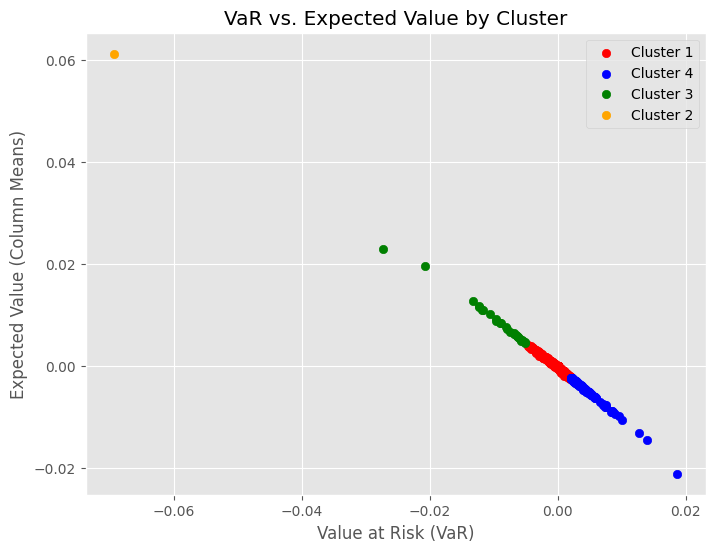

In [8]:
# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange']

# Plotting the graph for each cluster
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_kmeans['Cluster'].unique()):
    cluster_data_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]
    plt.scatter(cluster_data_kmeans['VaR'], expected_means[cluster_data_kmeans.index], color=colors[i], label=f'Cluster {cluster}')

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()


### Random 25 Stock Each Cluster
Untuk melihat detail persebaran lebih jelas, maka kita akan memilih 25 stock sebagai contoh

In [9]:
result_df_kmeans['Stocks'] = result_df_kmeans.index

# Fungsi untuk memilih tepat 25 nama saham acak per cluster jika tersedia
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Membuat DataFrame baru dengan maksimal 10 nama saham acak per cluster atau semua jika kurang dari 10
newstockslist_kmeans = select_random_stocks_per_cluster(result_df_kmeans)

print(newstockslist_kmeans)

         VaR  Cluster Stocks
0   0.001836        1   ALMI
1   0.001067        1   WGSH
2   0.000404        1   JKON
3   0.000903        1   INDO
4  -0.000932        1   CLEO
..       ...      ...    ...
71  0.007426        4   FUJI
72  0.007552        4   APEX
73  0.002845        4   NFCX
74  0.002581        4   BVIC
75  0.002830        4   KRAS

[76 rows x 3 columns]


### Pin Point Clusters K-Means of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

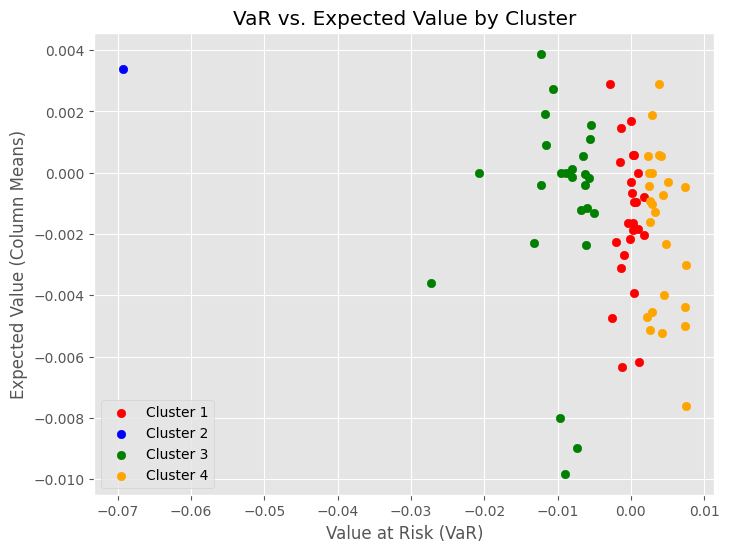

In [10]:
newclusters_kmeans = newstockslist_kmeans['Cluster'].unique()

# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange']

# Plotting the graph for each cluster
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_kmeans):
    cluster_data_kmeans = newstockslist_kmeans[newstockslist_kmeans['Cluster'] == cluster]
    plt.scatter(cluster_data_kmeans['VaR'], expected_means[cluster_data_kmeans.index], color=colors[i], label=f'Cluster {cluster}')

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Each Stock

In [11]:
stock_name = "BBCA"
cluster = result_df_kmeans[result_df_kmeans.index == stock_name]['Cluster'].values[0]

if cluster is not None:
    print(f"The stock {stock_name} is in Cluster {cluster}")
    print()

    # Find other stocks in the same cluster
    same_cluster_stocks_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]

    # Print the stocks in the same cluster
    print(f"Other stocks in Cluster {cluster}:")
    print(same_cluster_stocks_kmeans.head(5))

else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 1

Other stocks in Cluster 1:
           VaR  Cluster Stocks
AALI  0.000662        1   AALI
ABDA -0.000688        1   ABDA
ABMM  0.001484        1   ABMM
ADCP  0.001432        1   ADCP
ADES  0.000801        1   ADES


# ---------------------------------------------------------------------------

### **Agglomerative Algorithm**
Code di bawah berguna untuk melakukan clustering berdasarkan Algoritma Agglomerative 

In [12]:
# Standardize the data
scaler_aglo = StandardScaler()
var_data_standardized_aglo = scaler_aglo.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K = 4

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=K)
clusters_aglo = agg_cluster.fit_predict(var_data_standardized_aglo)

clusters_aglo = clusters_aglo + 1

# Display the resulting clusters
result_df_aglo = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_aglo})
print(result_df_aglo)

           VaR  Cluster
AALI  0.000662        3
ABBA  0.005853        2
ABDA -0.000688        3
ABMM  0.001484        3
ACES  0.002373        3
...        ...      ...
YULE -0.000074        3
ZBRA  0.000513        3
ZINC  0.003030        2
ZONE -0.000930        3
ZYRX  0.003637        2

[805 rows x 2 columns]


### Bar Plot Every Stocks Cluster Agglomerative
Code di bawah berguna untuk memvisualisasikan data persebaran berdasarkan Expected Values dan VaR dari algoritma Agglomerative

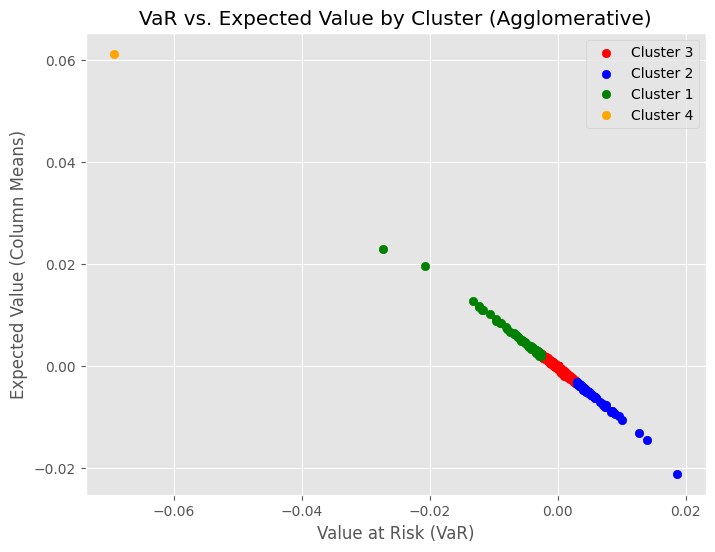

In [13]:
# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange']

# Plotting the graph for each cluster
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_aglo['Cluster'].unique()):
    cluster_data_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster]
    plt.scatter(cluster_data_aglo['VaR'], expected_means[cluster_data_aglo.index], color=colors[i], label=f'Cluster {cluster}')

plt.title('VaR vs. Expected Value by Cluster (Agglomerative)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster
Untuk melihat data lebih jelas, maka diambil 25 stock per cluster untuk di visualisasikan

In [14]:
result_df_aglo['Stocks'] = result_df_aglo.index

# Fungsi untuk memilih tepat 25 nama saham acak per cluster jika tersedia
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Membuat DataFrame baru dengan maksimal 10 nama saham acak per cluster atau semua jika kurang dari 10
newstockslist_aglo = select_random_stocks_per_cluster(result_df_aglo)

print(newstockslist_aglo)

         VaR  Cluster Stocks
0  -0.002901        1   BPII
1  -0.003802        1   MAPB
2  -0.005694        1   TRIS
3  -0.027261        1   OASA
4  -0.004032        1   GULA
..       ...      ...    ...
71 -0.000000        3   MABA
72  0.002863        3   PAMG
73  0.001350        3   BBTN
74  0.000655        3   PLIN
75 -0.069361        4   EXCL

[76 rows x 3 columns]


### Pin Point Clusters Agglomerative of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

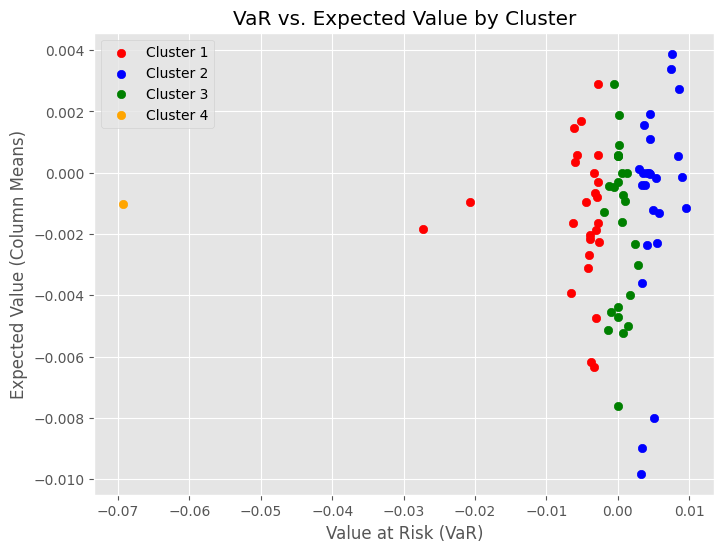

In [15]:
newclusters_aglo = newstockslist_aglo['Cluster'].unique()

# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange']

# Plotting the graph for each cluster
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_aglo):
    cluster_data_aglo = newstockslist_aglo[newstockslist_aglo['Cluster'] == cluster]
    plt.scatter(cluster_data_aglo['VaR'], expected_means[cluster_data_aglo.index], color=colors[i], label=f'Cluster {cluster}')

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Each Stock

In [16]:
stock_name = "BBCA"
cluster = result_df_aglo[result_df_aglo.index == stock_name]['Cluster'].values[0]

if cluster is not None:
    print(f"The stock {stock_name} is in Cluster {cluster}")
    print()

    # Find other stocks in the same cluster
    same_cluster_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster]

    # Print the stocks in the same cluster
    print(f"Other stocks in Cluster {cluster}:")
    print(same_cluster_aglo.head(5))

else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 3

Other stocks in Cluster 3:
           VaR  Cluster Stocks
AALI  0.000662        3   AALI
ABDA -0.000688        3   ABDA
ABMM  0.001484        3   ABMM
ACES  0.002373        3   ACES
ACST  0.002911        3   ACST


# ---------------------------------------------------------------------------

### **GMM Algorithm**
Code dibawah berguna untuk melakukan implementasi dari algoritma GMM dalam melakukan Clustering

In [17]:
from sklearn.mixture import GaussianMixture

# Standardize the data
scaler_gmm = StandardScaler()
var_data_standardized_gmm = scaler_gmm.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K_gmm = 4  # Jumlah cluster yang diinginkan

# Perform GMM Clustering
gmm_cluster = GaussianMixture(n_components=K_gmm, random_state=42)
clusters_gmm = gmm_cluster.fit_predict(var_data_standardized_gmm)

clusters_gmm = clusters_gmm + 1

# Display the resulting clusters
result_df_gmm = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_gmm})
print(result_df_gmm)


           VaR  Cluster
AALI  0.000662        4
ABBA  0.005853        2
ABDA -0.000688        4
ABMM  0.001484        4
ACES  0.002373        4
...        ...      ...
YULE -0.000074        4
ZBRA  0.000513        4
ZINC  0.003030        2
ZONE -0.000930        4
ZYRX  0.003637        2

[805 rows x 2 columns]


### Bar Plot Every Stocks Cluster GMM
Berikut merupakan Visualisasi seluruh stock berdasarkan Expected Values dan VaR dari Algoritma GMM

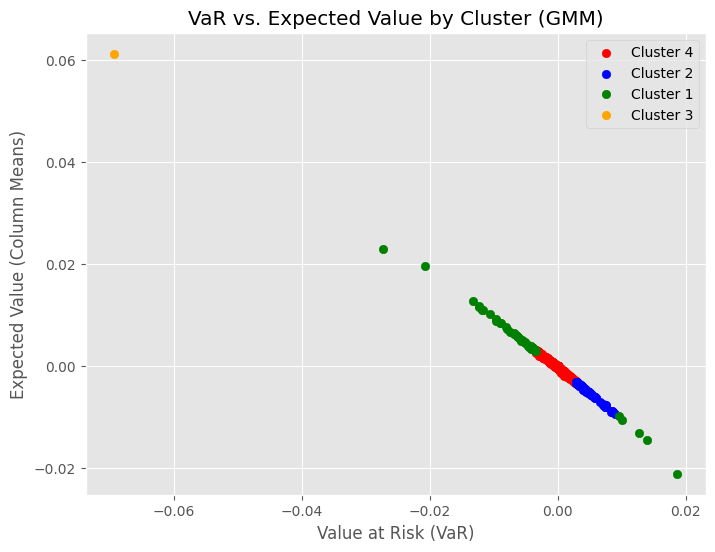

In [18]:
# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange']

# Plotting the graph for each cluster
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_gmm['Cluster'].unique()):
    cluster_data_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster]
    plt.scatter(cluster_data_gmm['VaR'], expected_means[cluster_data_gmm.index], color=colors[i], label=f'Cluster {cluster}')

plt.title('VaR vs. Expected Value by Cluster (GMM)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster
Untuk melihat data lebih jelas, maka diambil 25 stock per cluster untuk di visualisasikan

In [19]:
result_df_gmm['Stocks'] = result_df_gmm.index

# Fungsi untuk memilih tepat 25 nama saham acak per cluster jika tersedia
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Membuat DataFrame baru dengan maksimal 10 nama saham acak per cluster atau semua jika kurang dari 10
newstockslist_gmm = select_random_stocks_per_cluster(result_df_gmm)

print(newstockslist_gmm)

         VaR  Cluster Stocks
0   0.010065        1   INPS
1  -0.003610        1   BLTZ
2  -0.003826        1   MASA
3  -0.013247        1   EURO
4  -0.005590        1   DEWI
..       ...      ...    ...
71  0.000404        4   JKON
72  0.001889        4   PEHA
73  0.001567        4   NOBU
74 -0.001992        4   APLN
75  0.000361        4   BINO

[76 rows x 3 columns]


### Pin Point Clusters GMM of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

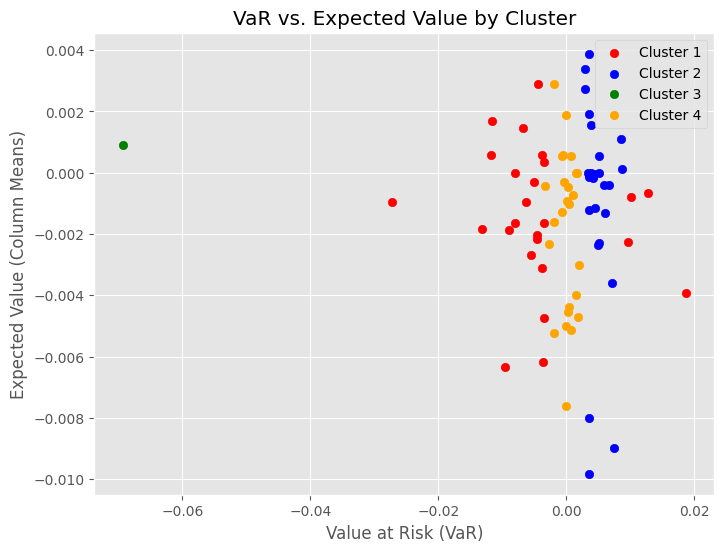

In [20]:
newclusters_gmm = newstockslist_gmm['Cluster'].unique()

# Define colors for each cluster
colors = ['red', 'blue', 'green', 'orange']

# Plotting the graph for each cluster
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_gmm):
    cluster_data_gmm = newstockslist_gmm[newstockslist_gmm['Cluster'] == cluster]
    plt.scatter(cluster_data_gmm['VaR'], expected_means[cluster_data_gmm.index], color=colors[i], label=f'Cluster {cluster}')

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Each Stock

In [21]:
stock_name = "BBCA"
cluster = result_df_gmm[result_df_gmm.index == stock_name]['Cluster'].values[0]

if cluster is not None:
    print(f"The stock {stock_name} is in Cluster {cluster}")
    print()

    # Find other stocks in the same cluster
    same_cluster_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster]

    # Print the stocks in the same cluster
    print(f"Other stocks in Cluster {cluster}:")
    print(same_cluster_gmm.head(5))

else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 4

Other stocks in Cluster 4:
           VaR  Cluster Stocks
AALI  0.000662        4   AALI
ABDA -0.000688        4   ABDA
ABMM  0.001484        4   ABMM
ACES  0.002373        4   ACES
ADCP  0.001432        4   ADCP


# ---------------------------------------------------------------------------
# COMPARISON
# ---------------------------------------------------------------------------

### Mean VaR of Clusters Analysis Based On Algorithm
Untuk mengetahui persamaan cluster dari setiap algoritma, maka perlu dilakukannya analisis berdasarkan mean VaR dari setiap clusternya

### K-Means Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma K-Means

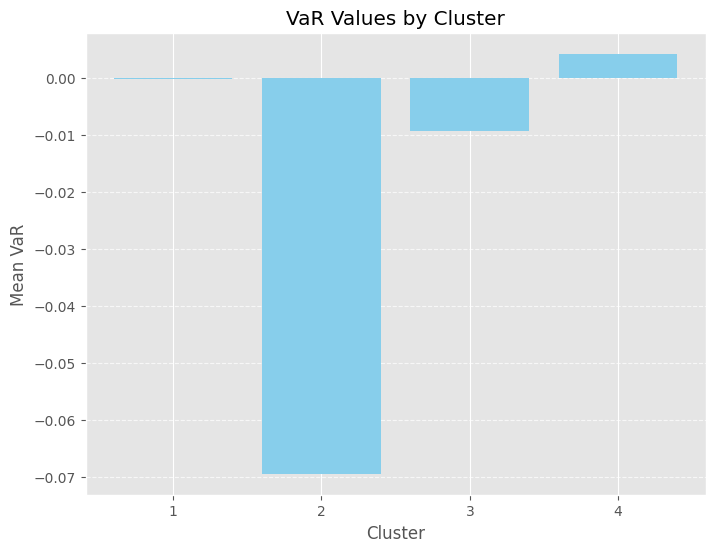

In [22]:
grouped_df_kmeans = result_df_kmeans.groupby('Cluster')['VaR'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(grouped_df_kmeans['Cluster'], grouped_df_kmeans['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster')
plt.xticks(grouped_df_kmeans['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Agglomerative Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma Aggloemerative

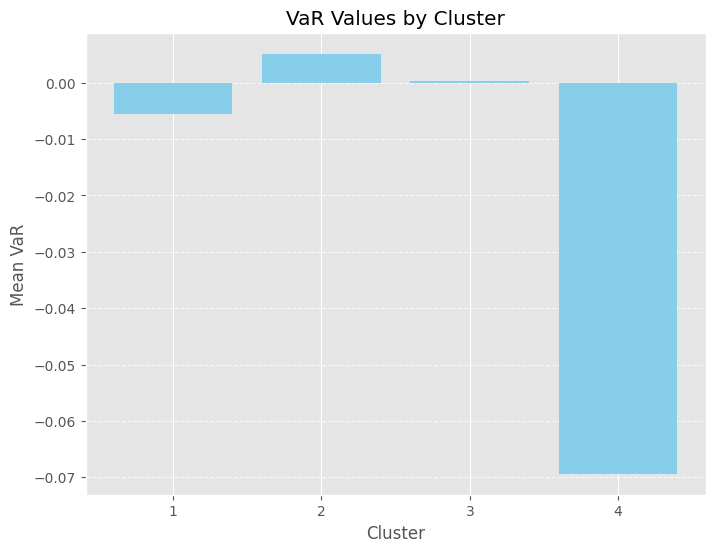

In [23]:
grouped_df_aglo = result_df_aglo.groupby('Cluster')['VaR'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(grouped_df_aglo['Cluster'], grouped_df_aglo['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster')
plt.xticks(grouped_df_aglo['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### GMM Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma GMM

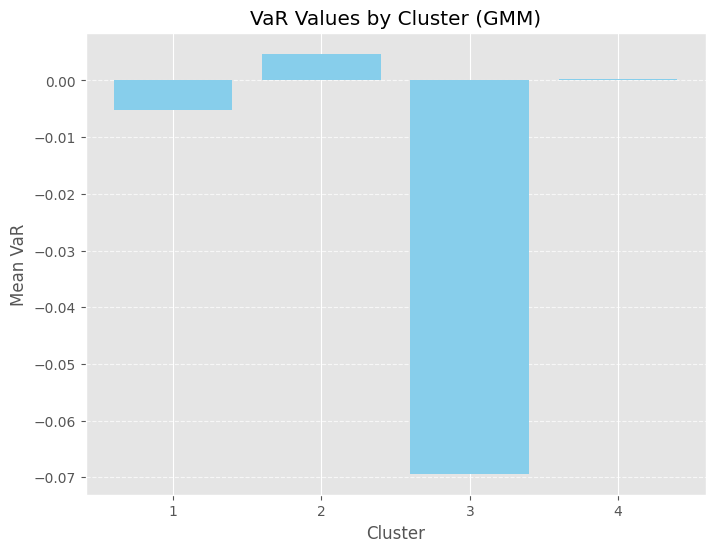

In [24]:
grouped_df_gmm = result_df_gmm.groupby('Cluster')['VaR'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(grouped_df_gmm['Cluster'], grouped_df_gmm['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster (GMM)')
plt.xticks(grouped_df_gmm['Cluster'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Perbandingan 3 Algoritma
Berikut adalah grafik perbandingan Mean VaR pada setiap cluster

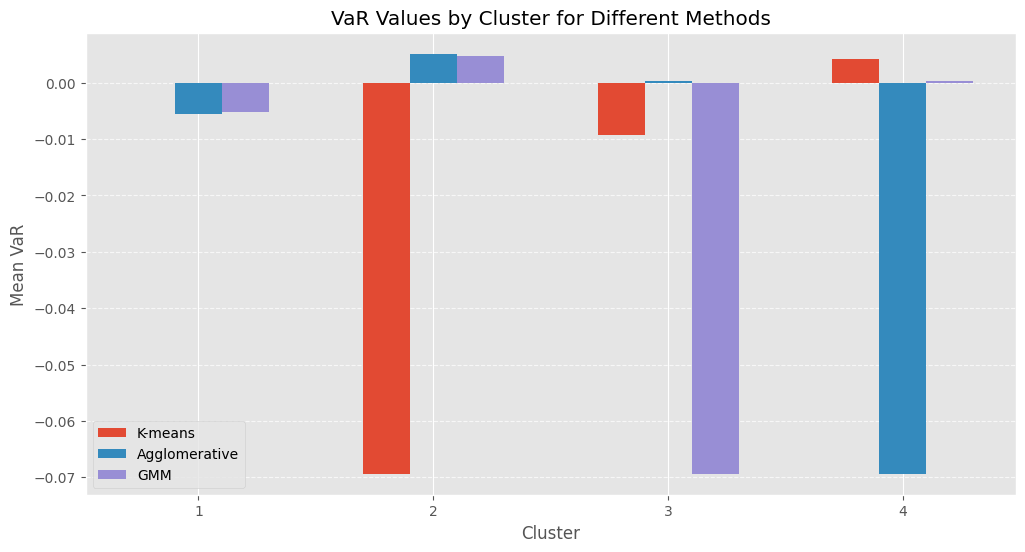

In [25]:
# Width of the bars
bar_width = 0.2

# Generate x-axis values for each cluster for each method
x_kmeans = np.arange(len(grouped_df_kmeans)) 
x_aglo = np.arange(len(grouped_df_aglo)) + bar_width
x_gmm = np.arange(len(grouped_df_gmm)) + 2 * bar_width

plt.figure(figsize=(12, 6))

# Bar plot for K-means
plt.bar(x_kmeans, grouped_df_kmeans['VaR'], width=bar_width, label='K-means')

# Bar plot for Agglomerative clustering
plt.bar(x_aglo, grouped_df_aglo['VaR'], width=bar_width, label='Agglomerative')

# Bar plot for GMM
plt.bar(x_gmm, grouped_df_gmm['VaR'], width=bar_width, label='GMM')

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster for Different Methods')
plt.xticks(np.arange(len(grouped_df_gmm)) + bar_width, grouped_df_gmm['Cluster'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### Note
Urutan klaster tidak selalu menjamin urutan resiko yang konsisten. Ketika Anda melakukan clustering berdasarkan resiko saham, setiap klaster hanya menunjukkan kesamaan dalam karakteristik resiko di dalam klaster tersebut, tetapi tidak memastikan urutan yang konsisten antara klaster.

Ketika Anda mengelompokkan saham berdasarkan resiko, klaster yang berbeda hanya menunjukkan bahwa saham-saham di dalamnya memiliki tingkat resiko yang serupa, namun tidak ada jaminan bahwa resiko di suatu klaster pasti lebih rendah atau lebih tinggi daripada klaster lain.

### Cluster Sorting Based On The Mean VaR
Guna menyamakan cluster, maka perlu dilakukannya pengurutan cluster berdasarkan nilai Mean VaR nya

In [26]:
def get_cluster_summary(df, algorithm_name):
    # Extract numeric columns
    numeric_columns = df.select_dtypes(include='number')
    
    # Calculate mean values for each cluster
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    
    # Explicitly sort the mean values
    cluster_means_sorted = cluster_means.sort_values()
    
    # Create a DataFrame with mean values and cluster counts
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    
    return summary

# Get cluster summaries for each algorithm
kmeans_summary = get_cluster_summary(result_df_kmeans, 'K-Means')
aglo_summary = get_cluster_summary(result_df_aglo, 'Agglomerative')
gmm_summary = get_cluster_summary(result_df_gmm, 'GMM')

# Display the individual summaries
print("K-Means Cluster Summary:")
print(kmeans_summary)

print("\nAgglomerative Cluster Summary:")
print(aglo_summary)

print("\nGMM Cluster Summary:")
print(gmm_summary)

K-Means Cluster Summary:
         Mean VaR  Counts
Cluster                  
2       -0.069361       1
3       -0.009335      27
1       -0.000136     600
4        0.004220     177

Agglomerative Cluster Summary:
         Mean VaR  Counts
Cluster                  
4       -0.069361       1
1       -0.005561      73
3        0.000366     615
2        0.005125     116

GMM Cluster Summary:
         Mean VaR  Counts
Cluster                  
3       -0.069361       1
1       -0.005207      49
4        0.000203     641
2        0.004720     114


### Change of Cluster Order based On The Sorted Mean VaR
Dengan data yang di dapatkan, maka kita akan melakukan perubahan nama cluster untuk menyesuaikan ketiga algoritma

In [27]:
# Membuat salinan DataFrame tanpa merubah yang asli
newresult_df_kmeans = result_df_kmeans.copy()
newresult_df_aglo = result_df_aglo.copy()
newresult_df_gmm = result_df_gmm.copy()

# Mengganti nilai sesuai dengan pola yang Anda sebutkan
newresult_df_kmeans['Cluster'] = newresult_df_kmeans['Cluster'].replace({kmeans_summary.index[0]: 1, kmeans_summary.index[1]:2, kmeans_summary.index[2]: 3, kmeans_summary.index[3]:4})
newresult_df_aglo['Cluster'] = newresult_df_aglo['Cluster'].replace({aglo_summary.index[0]: 1, aglo_summary.index[1]: 2, aglo_summary.index[2]: 3,aglo_summary.index[3]:4})
newresult_df_gmm['Cluster'] = newresult_df_gmm['Cluster'].replace({gmm_summary.index[0]: 1, gmm_summary.index[1]: 2, gmm_summary.index[2]: 3, gmm_summary.index[3]: 4})

### Comparison of The Number of Stocks in Every Cluster
Berikut merupakan gambaran dari jumlah stocks di tiap Cluster

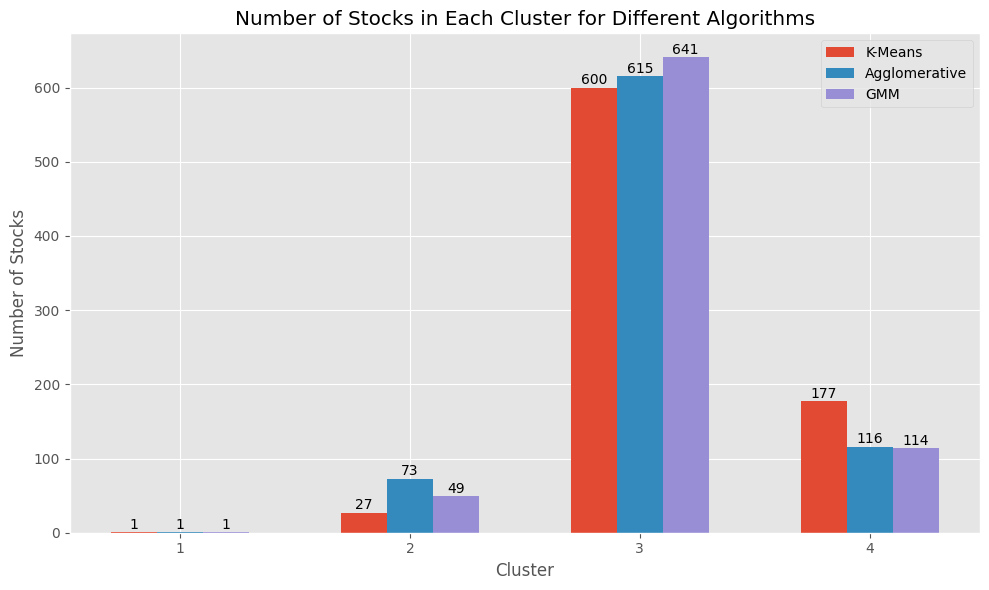

In [28]:
import matplotlib.pyplot as plt

# Count the number of stocks in each cluster for each DataFrame
kmeans_cluster_counts = newresult_df_kmeans['Cluster'].value_counts().sort_index()
aglo_cluster_counts = newresult_df_aglo['Cluster'].value_counts().sort_index()
gmm_cluster_counts = newresult_df_gmm['Cluster'].value_counts().sort_index()

# Create a bar plot to compare the number of stocks in each cluster for each algorithm
plt.figure(figsize=(10, 6))

bar_width = 0.2
index = kmeans_cluster_counts.index  # Assuming clusters are the same across all DataFrames

plt.bar(index - bar_width, kmeans_cluster_counts, width=bar_width, label='K-Means')
plt.bar(index, aglo_cluster_counts, width=bar_width, label='Agglomerative')
plt.bar(index + bar_width, gmm_cluster_counts, width=bar_width, label='GMM')

# Displaying count values on top of each bar
for i, v in enumerate(kmeans_cluster_counts):
    plt.text(i + 1 - bar_width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(aglo_cluster_counts):
    plt.text(i+1, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(gmm_cluster_counts):
    plt.text(i + 1 + bar_width, v + 0.5, str(v), ha='center', va='bottom')

plt.xlabel('Cluster')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Cluster for Different Algorithms')
plt.xticks(index)
plt.legend()
plt.tight_layout()
plt.show()



### Stock Cluster 1
Berikut merupakan data Stock yang berada pada cluster 1 di setiap algoritma

In [29]:
# Memilih saham dengan cluster 1 dari setiap algoritma
stocks_kmeans_cluster1 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 1]['Stocks']
stocks_aglo_cluster1 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 1]['Stocks']
stocks_gmm_cluster1 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 1]['Stocks']

# Menemukan saham yang memiliki cluster 1 di ketiga algoritma
stocks_in_clusters1 = set(stocks_kmeans_cluster1) & set(stocks_aglo_cluster1) & set(stocks_gmm_cluster1)


# Memeriksa jika saham memiliki cluster yang sama di semua algoritma
print("Stock berikut memiliki cluster 1 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters1))


Stock berikut memiliki cluster 1 di ketiga algoritma:
'EXCL'


### Stock Cluster 2
Berikut merupakan data Stock yang berada pada cluster 2 di setiap algoritma

In [30]:
# Memilih saham dengan cluster 2 dari setiap algoritma
stocks_kmeans_cluster2 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 2]['Stocks']
stocks_aglo_cluster2 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 2]['Stocks']
stocks_gmm_cluster2 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 2]['Stocks']

# Menemukan saham yang memiliki cluster 2 di ketiga algoritma
stocks_in_clusters2 = set(stocks_kmeans_cluster2) & set(stocks_aglo_cluster2) & set(stocks_gmm_cluster2)

# Memeriksa jika saham memiliki cluster yang sama di semua algoritma
print("Stock berikut memiliki cluster 2 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters2))

Stock berikut memiliki cluster 2 di ketiga algoritma:
'SKRN', 'PORT', 'SDPC', 'IBOS', 'MPRO', 'SRAJ', 'KONI', 'ETWA', 'MTSM', 'SINI', 'GLVA', 'BYAN', 'EURO', 'DEWI', 'FMII', 'MRAT', 'TRIS', 'SMKM', 'OASA', 'PTIS', 'LION', 'NZIA', 'PANR', 'HRTA', 'BUAH', 'FITT', 'NICL'


### Stock Cluster 3
Berikut merupakan data Stock yang berada pada cluster 3 di setiap algoritma

In [31]:
# Memilih saham dengan cluster 3 dari setiap algoritma
stocks_kmeans_cluster3 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 3]['Stocks']
stocks_aglo_cluster3 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 3]['Stocks']
stocks_gmm_cluster3 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 3]['Stocks']

# Menemukan saham yang memiliki cluster 3 di ketiga algoritma
stocks_in_clusters3 = set(stocks_kmeans_cluster3) & set(stocks_aglo_cluster3) & set(stocks_gmm_cluster3)

# Memeriksa jika saham memiliki cluster yang sama di semua algoritma
print("Stock berikut memiliki cluster 3 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters3))

Stock berikut memiliki cluster 3 di ketiga algoritma:
'PURE', 'EKAD', 'ASRM', 'BTON', 'UNSP', 'MBSS', 'HADE', 'BUVA', 'STAR', 'WOWS', 'CEKA', 'DPUM', 'BWPT', 'CFIN', 'LPIN', 'MKNT', 'VICI', 'JECC', 'ELTY', 'TAMA', 'KBLM', 'TRJA', 'RSGK', 'PTBA', 'UNVR', 'POLY', 'MTFN', 'SAME', 'PICO', 'INCI', 'GPSO', 'BMSR', 'MTLA', 'SDMU', 'DMND', 'BRMS', 'MMLP', 'GEMS', 'SAFE', 'KOIN', 'BSWD', 'GHON', 'ASBI', 'REAL', 'BMAS', 'SMCB', 'MERK', 'CSAP', 'TSPC', 'BAUT', 'BHAT', 'IRRA', 'CBMF', 'ELPI', 'PTSN', 'TOTL', 'AMAG', 'TRAM', 'TOWR', 'JSMR', 'PUDP', 'GAMA', 'MIKA', 'BUKK', 'CTTH', 'EAST', 'IKAN', 'GDST', 'KOPI', 'PZZA', 'WICO', 'WEHA', 'IPCM', 'LSIP', 'OILS', 'LCKM', 'WSBP', 'RIMO', 'SSTM', 'INPP', 'KDSI', 'UNIQ', 'GOOD', 'ZONE', 'KIJA', 'PTPW', 'MTRA', 'YPAS', 'NUSA', 'TRUK', 'JGLE', 'CMNT', 'BMHS', 'ERAA', 'HRME', 'LMPI', 'CLAY', 'IMJS', 'MINA', 'SOTS', 'ASGR', 'TCPI', 'TPMA', 'RCCC', 'NTBK', 'CAMP', 'PDES', 'KEJU', 'SIDO', 'CPRI', 'DUTI', 'INAI', 'IBFN', 'AMFG', 'TBMS', 'CASS', 'JTPE', 'SOCI', 'P

### Stock Cluster 4
Berikut merupakan data Stock yang berada pada cluster 4 di setiap algoritma

In [32]:
# Memilih saham dengan cluster 4 dari setiap algoritma
stocks_kmeans_cluster4 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 4]['Stocks']
stocks_aglo_cluster4 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 4]['Stocks']
stocks_gmm_cluster4 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 4]['Stocks']

# Menemukan saham yang memiliki cluster 4 di ketiga algoritma
stocks_in_clusters4 = set(stocks_kmeans_cluster4) & set(stocks_aglo_cluster4) & set(stocks_gmm_cluster4)

# Memeriksa jika saham memiliki cluster yang sama di semua algoritma
print("Stock berikut memiliki cluster 4 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters4))

Stock berikut memiliki cluster 4 di ketiga algoritma:
'ASHA', 'AYLS', 'WIFI', 'BOLA', 'LUCK', 'CENT', 'PTPP', 'BSML', 'FREN', 'BGTG', 'LAND', 'BPFI', 'MCAS', 'CMPP', 'FILM', 'BUMI', 'MLPL', 'OPMS', 'MGLV', 'PTDU', 'KRYA', 'NICK', 'SICO', 'PSDN', 'KINO', 'TOOL', 'BEBS', 'KKGI', 'RANC', 'ROCK', 'BCAP', 'RAFI', 'HITS', 'GIAA', 'POLU', 'ARTO', 'INDR', 'RIGS', 'IPTV', 'GEMA', 'BAPA', 'ATAP', 'ZYRX', 'HDIT', 'ABBA', 'BBYB', 'AXIO', 'JAST', 'BIMA', 'MPOW', 'INCF', 'ASMI', 'TRIM', 'RICY', 'META', 'WIKA', 'KLIN', 'WMUU', 'SATU', 'SWAT', 'MDLN', 'NASI', 'WMPP', 'MARI', 'ZINC', 'EMTK', 'PTSP', 'ASSA', 'GOTO', 'SWID', 'POLL', 'BBHI', 'ESTI', 'ECII', 'TOYS', 'WSKT', 'PCAR', 'BBKP', 'AHAP', 'APEX', 'HOMI', 'FUJI', 'MPPA', 'LABA', 'JMAS', 'ESTA', 'NANO', 'LINK', 'DEWA', 'AMMS', 'FIRE', 'SEMA', 'ADHI', 'WIRG', 'ASLC', 'KBLV', 'FPNI', 'MSKY', 'RODA', 'AGRO', 'DMMX', 'SGER', 'BNBA', 'CASH', 'ICON', 'MNCN', 'IPPE', 'IATA', 'TNCA', 'ARGO', 'TOBA'


# ---------------------------------------------------------------------------
## Features
# ---------------------------------------------------------------------------

### Note
1. Nilai VaR Mendekati -1:

Jika nilai VaR mendekati -1, itu mungkin menunjukkan bahwa kerugian potensial terkait dengan investasi Anda cenderung terjadi dengan kepastian yang relatif tinggi. Ini berarti ada kemungkinan tinggi bahwa kerugian besar akan terjadi, terutama pada level kepercayaan tertentu (misalnya, 95% atau 99%).
Bagi seorang pemain saham yang suka risiko tinggi, ini mungkin menjadi pilihan karena ada potensi untuk keuntungan yang lebih besar, tetapi juga risiko kerugian yang signifikan.

2. Nilai VaR Mendekati 1:

jika nilai VaR mendekati 1, itu menunjukkan bahwa risiko investasi lebih rendah. Ini berarti bahwa kemungkinan kerugian besar dalam periode tertentu cenderung lebih rendah.
Bagi seorang pemain saham yang ingin menghindari risiko tinggi, ini mungkin menjadi pilihan karena menawarkan perlindungan relatif terhadap kerugian besar, meskipun keuntungannya mungkin juga lebih terbatas.

### Merging All The Clusters Into One Data Frame
Code dibawah berguna untuk melakukan penyatuan seluruh cluster kedalam satu dataframe

In [33]:
# Menggabungkan ketiga DataFrame berdasarkan kolom 'Stock' dan 'Cluster'
finalresult_df = pd.merge(newresult_df_kmeans, newresult_df_aglo, on=['VaR', 'Stocks', 'Cluster'])
finalresult_df = pd.merge(finalresult_df, newresult_df_gmm, on=['VaR', 'Stocks', 'Cluster'])

print(finalresult_df)

          VaR  Cluster Stocks
0    0.000662        3   AALI
1    0.005853        4   ABBA
2   -0.000688        3   ABDA
3    0.001484        3   ABMM
4    0.001432        3   ADCP
..        ...      ...    ...
688 -0.000074        3   YULE
689  0.000513        3   ZBRA
690  0.003030        4   ZINC
691 -0.000930        3   ZONE
692  0.003637        4   ZYRX

[693 rows x 3 columns]


### Feature 1
#### Testing a specific Stock to where it falls in cluster while also recommending some stocks that fall in the same cluster.

The stock BBCA is in Cluster 3
Investasi dalam saham BBCA cenderung menunjukkan tingkat risiko yang relatif terkendali, namun 
tidak berada pada level risiko terendah. Hal ini memungkinkan fluktuasi nilai yang masih dapat diantisipasi, 
dengan potensi terjadinya kerugian atau keuntungan yang moderat dalam jangka waktu tertentu.

5 saham dengan nilai VaR tertinggi di Cluster 3:
          VaR Stocks  Cluster
202  0.002045   DOID        3
162  0.002040   CLAY        3
111  0.002038   BMTR        3
387  0.002025   LMPI        3
641  0.002007   TOWR        3


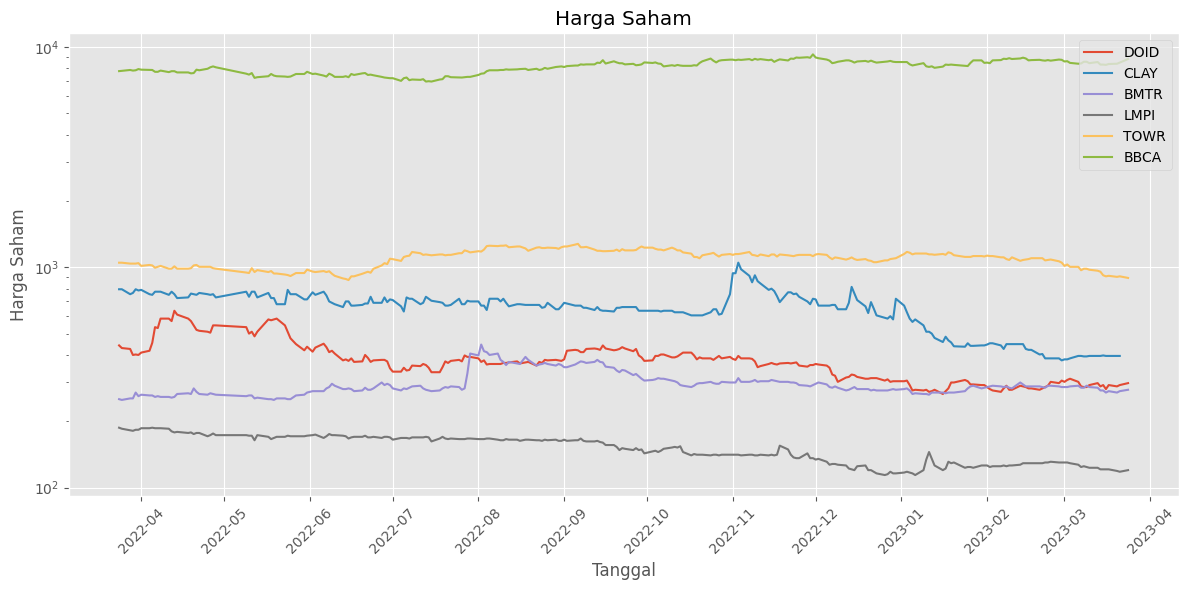

In [34]:
stock_name = "BBCA"
cluster_final = finalresult_df[finalresult_df.Stocks == stock_name]['Cluster']

if not cluster_final.empty:
    clusters_found = cluster_final.unique()  # Mengambil nilai cluster yang unik
    for cluster in clusters_found:
        if cluster == 1:
            print(f"The stock {stock_name} is in Cluster {cluster}\nInvestasi dalam saham {stock_name} memiliki potensi risiko yang signifikan, yang dapat menyebabkan\n fluktuasi nilai yang cepat dan berpotensi menghasilkan kerugian atau keuntungan yang substansial dalam waktu yang singkat.")
        elif cluster == 2:
            print(f"The stock {stock_name} is in Cluster {cluster}\nTingkat risiko yang terkait dengan investasi dalam saham {stock_name} menunjukkan kecenderungan stabil\n yang mungkin memiliki pengaruh yang cukup besar. Hal ini bisa menghasilkan perubahan nilai yang cepat dan berpotensi \nmengakibatkan kerugian atau keuntungan yang cukup besar dalam waktu singkat.")
        elif cluster == 3:
            print(f"The stock {stock_name} is in Cluster {cluster}\nInvestasi dalam saham {stock_name} cenderung menunjukkan tingkat risiko yang relatif terkendali, namun \ntidak berada pada level risiko terendah. Hal ini memungkinkan fluktuasi nilai yang masih dapat diantisipasi, \ndengan potensi terjadinya kerugian atau keuntungan yang moderat dalam jangka waktu tertentu.")
        elif cluster == 4:
            print(f"The stock {stock_name} is in Cluster {cluster}\nTingkat risiko investasi dalam saham {stock_name} sangat terkendali dan cenderung aman. Hal ini menunjukkan\n kemungkinan fluktuasi nilai yang minimal, mengurangi potensi kerugian dan memperlihatkan stabilitas dalam \nmencapai keuntungan dalam jangka waktu yang singkat.")
        # Tambahkan kondisi lain jika ada nilai cluster lainnya
        else:
            print(f"The stock {stock_name} is in Cluster {cluster}")   
    print()

else:
    print(f"The stock {stock_name} was not found in any cluster")

# Filter DataFrame berdasarkan cluster tertentu
same_cluster_final = finalresult_df[finalresult_df['Cluster'] == cluster]

# Mengurutkan berdasarkan nilai VaR (dari tertinggi ke terendah)
sorted_cluster = same_cluster_final.sort_values(by='VaR', ascending=False)

# Mengambil 5 saham dengan nilai VaR tertinggi
top_5_highest_var = sorted_cluster.head(5)

# Menampilkan kolom VaR, Stocks, dan Cluster dari 5 saham dengan nilai VaR terendah
print(f"5 saham dengan nilai VaR tertinggi di Cluster {cluster}:")
print(top_5_highest_var[['VaR', 'Stocks', 'Cluster']])

# Ambil tanggal dan nama saham yang dipilih dari top_5_lowest_var
additional_stocksfix = top_5_highest_var['Stocks'].tolist()

# Tambahkan nama saham yang dipilih ke dalam list saham yang akan digambarkan
stocks_to_plot = additional_stocksfix + [stock_name]

# Filter DataFrame untuk saham-saham yang akan digambarkan
selected_stocks = prices_df[stocks_to_plot]

# Membuat grafik
plt.figure(figsize=(12, 6))

# Plot harga penutupan saham yang dipilih
for stock in stocks_to_plot:
    plt.semilogy(selected_stocks.index, selected_stocks[stock], label=stock)

plt.title('Harga Saham')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)

# Format tanggal di sumbu X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)  # Rotasi label tanggal untuk penampilan yang lebih baik
plt.tight_layout()  # Menata tata letak plot agar rapih
plt.show()


### Feature 2
#### Giving some stocks recommendation depending on the cluster risk level.

In [35]:
import random

# Memilih tingkat risiko
tingkat_resiko = "Resiko Sangat Rendah"  # Ganti dengan input yang sesuai

# Filtering berdasarkan tingkat risiko
if tingkat_resiko == "Resiko Tinggi":
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == 1]['Stocks']
elif tingkat_resiko == "Resiko Sedang":
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == 2]['Stocks']
elif tingkat_resiko == "Resiko Rendah":
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == 3]['Stocks']
elif tingkat_resiko == "Resiko Sangat Rendah":
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == 4]['Stocks']
else:
    print("Tingkat risiko tidak valid")

# Menampilkan rekomendasi
if 'emiten_cluster' in locals():
    if len(emiten_cluster) < 10:
        print(f"Rekomendasi emiten untuk tingkat {tingkat_resiko}:")
        for emiten in emiten_cluster:
            print(emiten)
    else:
        emiten_rekomendasi = random.sample(emiten_cluster.tolist(), k=10)
        print(f"Rekomendasi 10 emiten untuk tingkat '{tingkat_resiko}':")
        for emiten in emiten_rekomendasi:
            print(emiten)
else:
    print("Tidak ada rekomendasi untuk tingkat risiko yang dimasukkan")


Rekomendasi 10 emiten untuk tingkat 'Resiko Sangat Rendah':
ATAP
CMPP
HDIT
PCAR
POLU
AHAP
ADHI
PTPP
WMPP
LABA


# ---------------------------------------------------------------------------
## EVALUATION
# ---------------------------------------------------------------------------


### Silhouette Score

In [36]:
from sklearn.metrics import silhouette_score

# Ambil hasil clustering dari ketiga algoritma
test1_clusters_kmeans = result_df_kmeans['Cluster']  # Hasil clustering dari K-Means
test1_clusters_gmm = result_df_gmm['Cluster']   # Hasil clustering dari OPTICS
test1_clusters_aglo = result_df_aglo['Cluster']   # Hasil clustering dari Hierarchical Clustering atau Agglomerative Clustering

# Hitung silhouette score untuk setiap hasil clustering
silhouette_kmeans = silhouette_score(var_data_standardized_kmeans, test1_clusters_kmeans)
silhouette_gmm = silhouette_score(var_data_standardized_gmm, test1_clusters_gmm)
silhouette_aglo = silhouette_score(var_data_standardized_aglo, test1_clusters_aglo)

# Tampilkan hasil
print(f"Silhouette Score K-Means: {silhouette_kmeans}")
print(f"Silhouette Score GMM: {silhouette_gmm}")
print(f"Silhouette Score Agglomerative Clustering: {silhouette_aglo}")



Silhouette Score K-Means: 0.5978981482650096
Silhouette Score GMM: 0.5852926872340566
Silhouette Score Agglomerative Clustering: 0.6075276651591093


C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

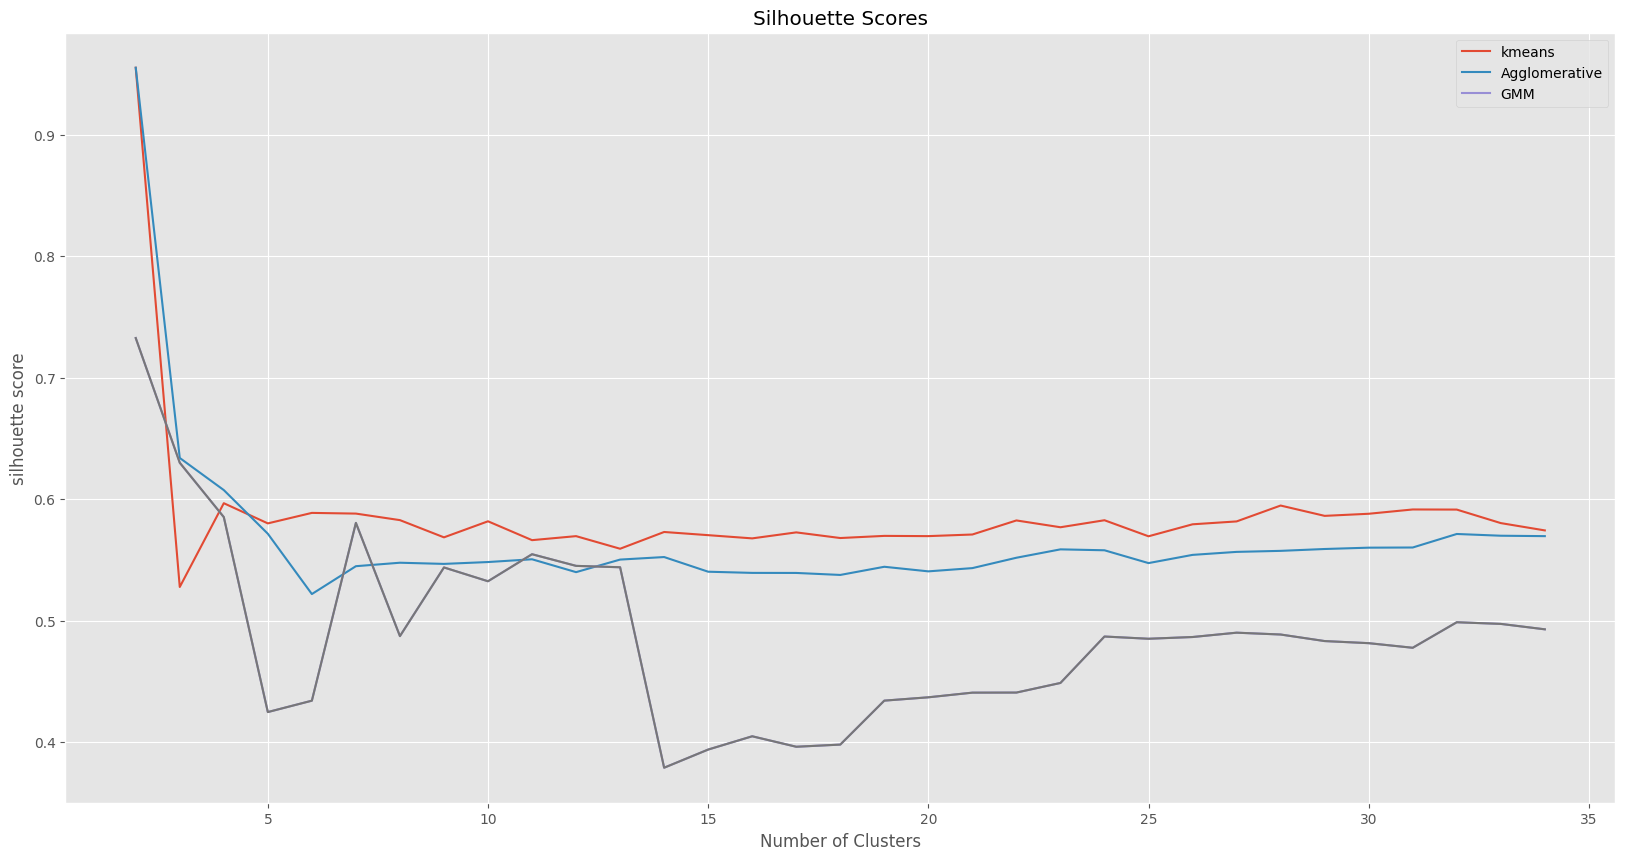

In [37]:
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster with different k's and plot
scores = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0)
    labels = km.fit_predict(var_data_standardized_kmeans)
    score = silhouette_score(var_data_standardized_kmeans,labels)
    scores.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster with 'linkage = average' with different n_cluster's and plot
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(var_data_standardized_aglo)
    score = silhouette_score(var_data_standardized_aglo,labels)
    scores.append(score)

plt.plot(clusters,scores)

scores = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(var_data_standardized_gmm)
    score = silhouette_score(var_data_standardized_gmm,labels)
    scores.append(score)

plt.plot(clusters,scores)

plt.plot(clusters,scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.legend(['kmeans','Agglomerative','GMM'])




### Davies-Bouldin Index

In [38]:
from sklearn.metrics import davies_bouldin_score

# Hitung Davies-Bouldin Index untuk setiap hasil clustering
db_index_kmeans = davies_bouldin_score(var_data_standardized_kmeans, test1_clusters_kmeans)
db_index_gmm = davies_bouldin_score(var_data_standardized_gmm, test1_clusters_gmm)
db_index_aglo = davies_bouldin_score(var_data_standardized_aglo, test1_clusters_aglo)

# Tampilkan hasil
print(f"Davies-Bouldin Index K-Means: {db_index_kmeans}")
print(f"Davies-Bouldin Index GMM: {db_index_gmm}")
print(f"Davies-Bouldin Index Agglomerative Clustering: {db_index_aglo}")


Davies-Bouldin Index K-Means: 0.4264345858535107
Davies-Bouldin Index GMM: 0.6781090615725989
Davies-Bouldin Index Agglomerative Clustering: 0.46072464389391216


C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 

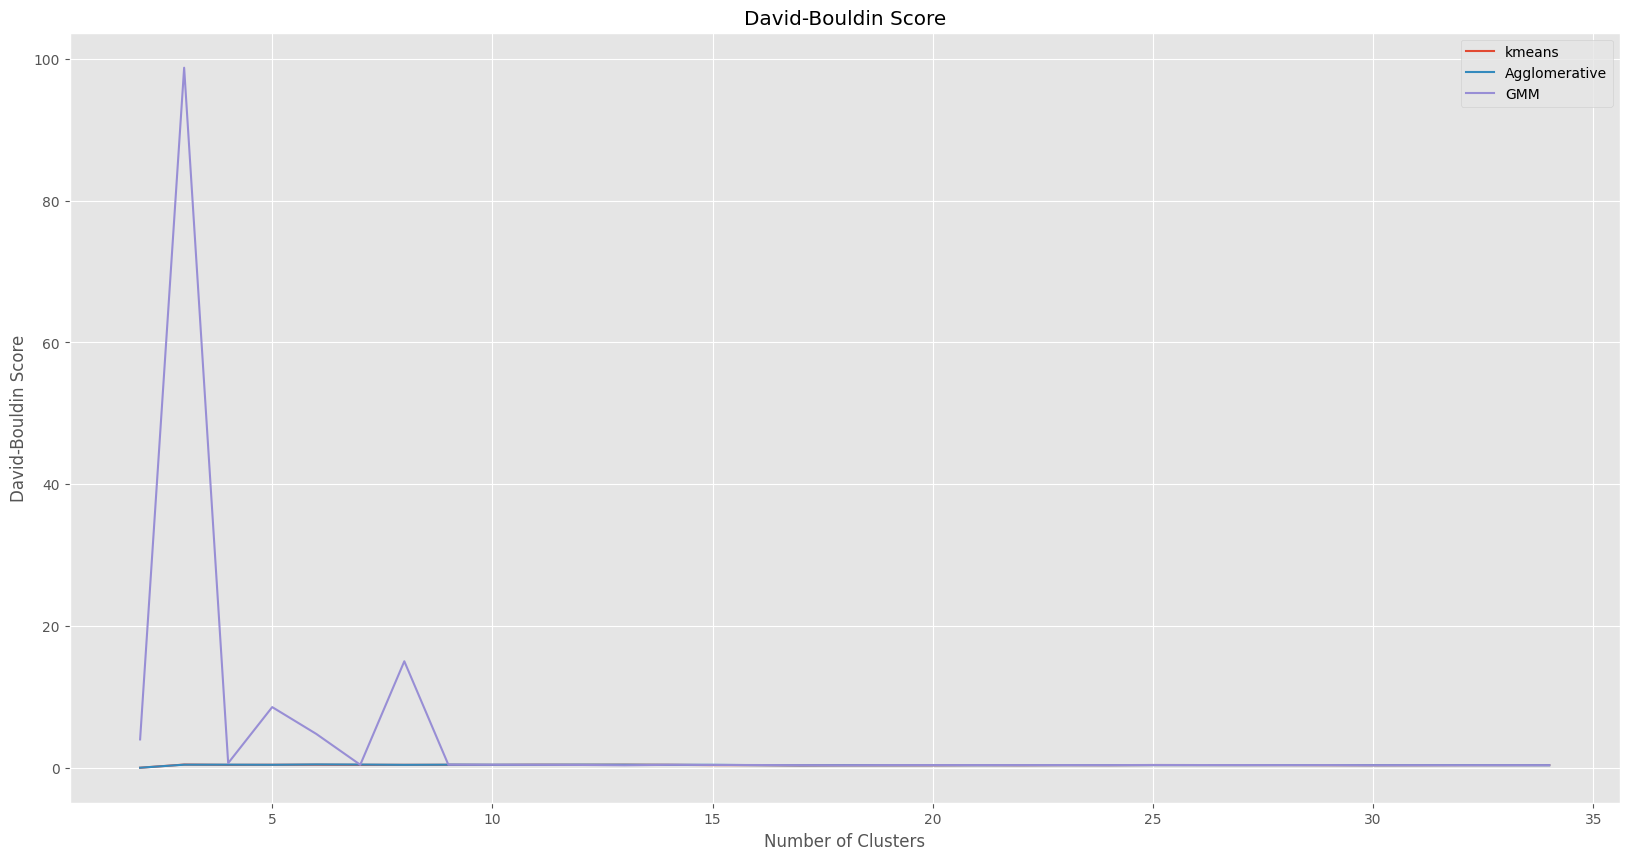

In [39]:
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster with different k's and plot
scores_dbi = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0)
    labels = km.fit_predict(var_data_standardized_kmeans)
    score = davies_bouldin_score(var_data_standardized_kmeans,labels)
    scores_dbi.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores_dbi)

# Compute the silhouette score for Agglomerative cluster with 'linkage = average' with different n_cluster's and plot
scores_dbi = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(var_data_standardized_aglo)
    score = davies_bouldin_score(var_data_standardized_aglo,labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

scores_dbi = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(var_data_standardized_gmm)
    score = davies_bouldin_score(var_data_standardized_gmm,labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

plt.title('David-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('David-Bouldin Score')
plt.legend(['kmeans','Agglomerative','GMM'])


